In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
PATH_MODELS = './models/'
PATH_IMAGES = './images/'

Memory leaks, but I don't know why and where!

## Loading model

In [3]:
with open('./models/imagenet_classes.txt') as f_classes:
    imagnet_classes = [l.strip() for l in f_classes.readlines()]

In [4]:
path_model = PATH_MODELS + 'tensorflow_vgg16_graph.tfmodel'

graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)

with tf.gfile.FastGFile(path_model, 'rb') as f_model:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f_model.read())

# t_input = tf.placeholder(np.float32, name='input')
t_input = tf.Variable(np.zeros((224, 224, 3)), dtype=tf.float32, name='input')
t_preprocessed = tf.expand_dims(t_input, 0)

tf.import_graph_def(graph_def, input_map={"images": t_preprocessed})
# tf.import_graph_def(graph_def)

In [5]:
layers = [op.name for op in graph.get_operations() if op.type == 'Conv2D' and 'import/' in op.name]
feature_nums = {name: int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers}

print('Number of layers', len(layers))
print('Total number of feature channels:', sum(feature_nums.values()))

('Number of layers', 13)
('Total number of feature channels:', 4224)


## Plot tensorflow graph for model

In [5]:
from IPython.display import clear_output, Image, display, HTML


def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = bytes("<stripped {} bytes>".format(size))
    return strip_def

  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def


def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:950px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))


In [7]:
show_graph(graph_def)

## Classification

In [6]:
from skimage.transform import resize
import PIL.Image
from io import BytesIO


def preprocess(img, crop=False):
    img = np.float32(img) / 255.0
    
    if crop:
        img = crop_image(img)
    
    return img


def crop_image(img):
    h_input, w_input = 224, 224
    
    h, w, _ = img.shape
    if h < w:
        size_ = (h_input, w_input * w / h)
    else:
        size_ = (h_input * h / w, w_input)
    img = resize(img, size_, preserve_range=True) 
        
    h, w, _ = img.shape
    img = img[(h - h_input) // 2 : (h + h_input) // 2,
              (w - w_input) // 2 : (w + w_input) // 2]
    
    return img


def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 1) * 255)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    

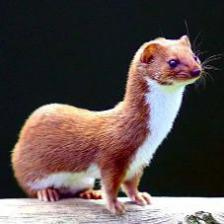

In [7]:
img0 = PIL.Image.open('laska.jpg')
img0 = preprocess(img0, crop=True)
showarray(img0)

In [12]:
prob = sess.run(graph.get_tensor_by_name('import/prob:0'), {t_input:img0})
imagnet_classes[np.argmax(prob)]

'n02441942 weasel'

## Feature interpretation

In [7]:
t_lr = tf.placeholder(tf.float32, name='learning_rate')
optimizer = tf.train.AdamOptimizer(learning_rate=t_lr)

In [8]:
# img_noise = np.random.uniform(size=(224,224,3)) + 100.0
img_noise = np.random.uniform(0.0, 1.0, size=(224,224,3))


def T(layer):
    return graph.get_tensor_by_name("import/{}:0".format(layer))


def normalize_image(img, std=0.1):
    return (img - img.mean()) / max(img.std(), 1e-4) * std + 0.5


In [9]:
def feature_interpretation(t_obj, img0=img_noise, iter_n=20, lr=2.0):
    t_score = tf.reduce_mean(t_obj)
    t_grad = optimizer.minimize(-t_score, var_list=[t_input])
    t_init = tf.initialize_all_variables()
    
    sess.run(t_init)
    sess.run(t_input.assign(img0))
   
    for i in range(iter_n):
        sess.run(t_grad, feed_dict={t_lr:lr})
        print sess.run(t_score),
    print '\n'
    
    img = normalize_image(sess.run(t_input))
    return img


In [22]:
layer = 'conv5_3/Conv2D'
features_n = int(T(layer).get_shape()[-1])
features_n

512

In [23]:
channel = 106

if channel < 0 or channel > features_n:
    raise NameException("Channel value is inappropriate")

-661.807 7110.53 15175.2 23376.7 32122.8 41752.8 52034.7 62993.4 74479.4 86192.1 98481.8 110975.0 123934.0 137108.0 150525.0 164312.0 178435.0 192948.0 207627.0 222458.0 237454.0 252721.0 268195.0 283975.0 299962.0 316046.0 332118.0 348469.0 365000.0 381691.0 398601.0 415714.0 433029.0 450501.0 468265.0 486174.0 504150.0 522281.0 540611.0 559085.0 



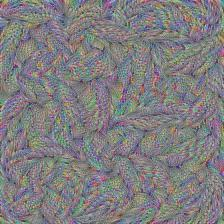

In [15]:
res_ = feature_interpretation(T(layer)[:,:,:,channel], iter_n=40, lr=4.0)
showarray(res_)

55.1
55.1
55.1
55.1
-92.3404 477.273 1659.34 3424.05 5780.02 8753.81 12224.6 16224.2 20617.6 25391.8 30499.1 35961.8 41785.4 47945.4 54518.8 61400.7 68550.6 75994.7 83774.1 91816.0 

56.1
56.1


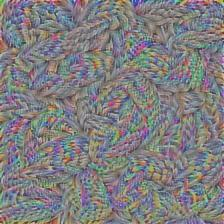

In [24]:
res_ = feature_interpretation(T(layer)[:,:,:,channel], img0=img0, iter_n=20)
showarray(res_)

In [21]:
n_class = 968

if n_class < 0 or n_class > 1000:
    raise NameException("Class number is inappropriate")

944.261 1998.64 3714.89 5554.43 7422.59 9660.55 12176.0 14868.2 17724.6 20605.6 23647.4 26846.2 30076.4 33433.8 37026.9 40577.5 44240.0 48042.5 51965.0 56025.1 60291.9 64645.5 69036.6 73548.2 78149.1 82884.0 87608.6 92472.7 97438.3 102414.0 107440.0 112529.0 117528.0 122552.0 127610.0 132729.0 137864.0 142965.0 148189.0 153428.0 



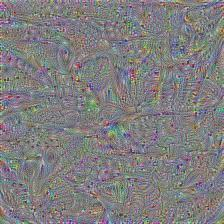

n07930864 cup


In [18]:
# res_ = feature_interpretation(T('prob')[:,n_class]) # prob doesn't increase :c
res_ = feature_interpretation(T('fc8/BiasAdd')[:,n_class], iter_n=40, lr=4.0)
showarray(res_)
print imagnet_classes[n_class]

In [19]:
prob = sess.run(graph.get_tensor_by_name('import/prob:0'), {t_input:_})
imagnet_classes[np.argmax(prob)], prob.max()

('n07930864 cup', 1.0)

## Multiscale feature interpretation

In [10]:
def calc_grad_tiled(img, t_grad, lr=2.0, tile_size=224):
    sz = tile_size
    h, w = img.shape[:2]
    
    sx, sy = np.random.randint(sz, size=2)
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    
    for y in range(0, max(h - sz//2, sz), sz):
        for x in range(0, max(w - sz//2, sz), sz):            
            t_init = tf.initialize_all_variables()
            
            sub = img_shift[y:y+sz, x:x+sz]
            if sub.shape != (224, 224, 3):
                h_, w_, d_ = sub.shape
                r = np.zeros((224, 224, 3))
                r[:h_,:w_,:d_] = sub[:,:,:]
                sub = r
            else:
                h_, w_, d_ = (224, 224, 3)
            
            sess.run(t_init)
            sess.run(t_input.assign(sub))
            sess.run(t_grad, feed_dict={t_lr:lr})
            
            img_shift[y:y+sz, x:x+sz] = sess.run(t_input)[:h_, :w_, :d_]
            
    return np.roll(np.roll(img_shift, -sx, 1), -sy, 0)


In [11]:
from scipy.ndimage.interpolation import zoom


def feature_interpretation_multiscale(t_obj, img0=img_noise, iter_n=10, octave_n=3, octave_scale=1.4, lr=2.0):
    t_score = tf.reduce_mean(t_obj)
    t_grad = optimizer.minimize(-t_score, var_list=[t_input])
    
    # img = img0.copy()
    img = img0
    
    for octave in range(octave_n):
        if octave:
            img = zoom(img, (octave_scale, octave_scale, 1), order=1)
        
        for i in range(iter_n):
            img = calc_grad_tiled(img, t_grad, lr=2.0)
            print '.',
            
        print 
    print '\n'
    
    img = normalize_image(img)
    return img


. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .




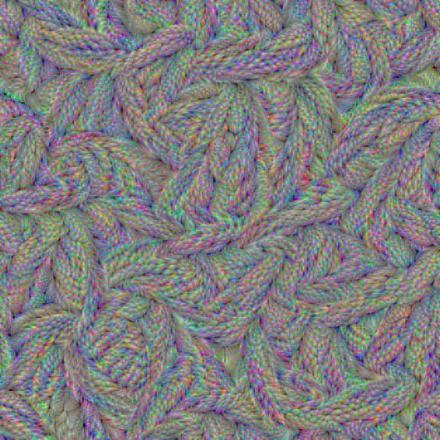

In [26]:
res_ = feature_interpretation_multiscale(T(layer)[:,:,:,channel], iter_n=30, lr=4.0)
showarray(res_)

. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .




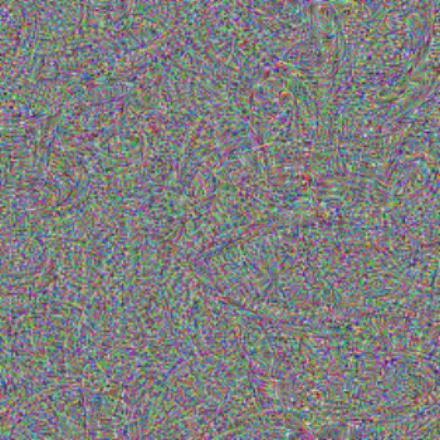

n07930864 cup


In [23]:
# _ = feature_interpretation_multiscale(T('prob')[:, n_class])
res_ = feature_interpretation_multiscale(T('fc8/BiasAdd')[:,n_class], iter_n=30, lr=4.0)
showarray(res_)
print imagnet_classes[n_class]

## Deepdream

In [ ]:
def deepdream(t_obj, img0=img_noise, iter_n=10, octave_n=4, octave_scale=1.4, lr=2.0):
    t_score = tf.reduce_mean(t_obj)
    t_grad = optimizer.minimize(-t_score, var_list=[t_input])

    # img = img0.copy()
    img = img0
    
    octaves = []
    for i in range(octave_n-1):
        hw = img.shape[:2]
        lo = zoom(img, (1.0/octave_scale, 1.0/octave_scale, 1), order=1)
        fr = img.shape / np.float32(lo.shape)
        hi = img - zoom(lo, fr)
        img = lo
        octaves.append(hi)
    
    for octave in range(octave_n):
        if octave:
            hi = octaves[-octave]
            fr = np.float32(hi.shape) / img.shape
            img = zoom(img, fr, order=1) + hi
        for i in range(iter_n):
            img = calc_grad_tiled(img, t_grad, lr)
            print '.',
        print
    
    clear_output()
    return img

In [ ]:
img0 = PIL.Image.open('image03_2.jpg')
img0 = preprocess(img0)
showarray(img0)

In [ ]:
n_class = 153

In [ ]:
res_ = deepdream(T('fc8/BiasAdd')[:,n_class], img0, lr=0.05, iter_n=1, octave_n=3)
# res_ = deepdream(T(layer)[:,:,:,channel], img0, lr=1.0, iter_n=5, octave_n=3)
showarray(res_)

In [ ]:
def postprocess(img):
    return np.uint8(np.clip(img * 255.0, 0, 255))

In [ ]:
import scipy.ndimage as nd
import os

DIR_FRAMES = './frames/'

if not os.path.exists(DIR_FRAMES):
    os.makedirs(DIR_FRAMES)
else:
    files = os.listdir(DIR_FRAMES)
    for f in files:
         os.remove(DIR_FRAMES + f)

frame = img0
frame_i = 0

frame_copy = postprocess(frame)
PIL.Image.fromarray(frame_copy).save(DIR_FRAMES + "%04d.jpg" % frame_i)
frame_i += 1

h, w = frame.shape[:2]
s = 0.05

# t_prob = tf.square(T('conv4_3/Relu'))
t_prob = T('fc8/BiasAdd')#[:,n_class]

for i in xrange(100):
    # if i % 10 == 0:
    #     t_prob = T('fc8/BiasAdd')[:, np.random.randint(1000)]
    # t_prob = T('prob')[:, np.random.randint(1000)]
    # t_prob = tf.reduce_max(T('prob'), reduction_indices=[1])
    frame = deepdream(t_prob, frame, lr=0.1, iter_n=1, octave_n=2)
    showarray(frame)
    frame_copy = postprocess(frame)
    PIL.Image.fromarray(frame_copy).save(DIR_FRAMES + "%04d.jpg" % frame_i)
    frame = nd.affine_transform(frame, [1 - s, 1 - s, 1], [h * s / 2, w * s / 2, 0], order=1)
    print frame_i
    frame_i += 1